In [36]:
#Importing the necessary libraries
import cv2
import math
import sys
import numpy as np
import matplotlib.pyplot as plt

Enter user height
156
Enter image path
/content/mwaist.png


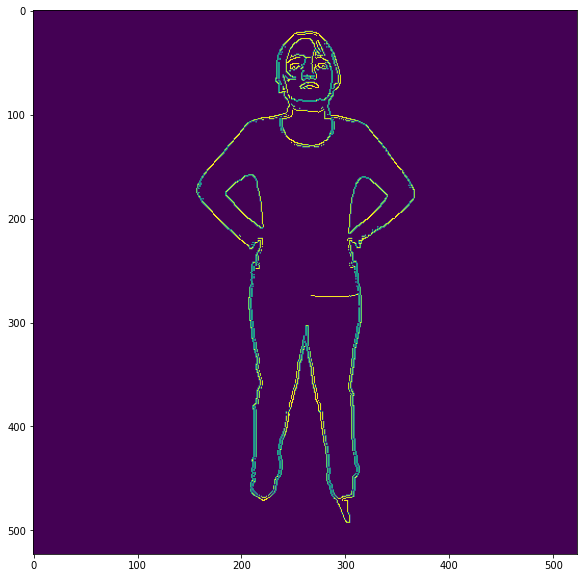

In [37]:
# Using opencv contour function to plot the contours of user image
print("Enter user height")
height=input()
print("Enter image path")
img_path=input()
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
flag, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)

# Find contours
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True) 

# Select long perimeters onl"y"
perimeters = [cv2.arcLength(contours[i],True) for i in range(len(contours))]
listindex = [i for i in range(15) if perimeters[i] > perimeters[0]/2]
numcards = len(listindex)

card_number = -1 #just so happened that this is the worst case
stencil = np.zeros(img.shape).astype(img.dtype)
cv2.drawContours(stencil, [contours[listindex[card_number]]], 0, (255, 255, 255), cv2.FILLED)
res = cv2.bitwise_and(img, stencil)
cnt = cv2.Canny(res, 100, 200)

plt.figure(figsize=[10,10])
plt.imshow(cnt)

In [38]:
# The body points calculated by our model
# replace them with the points calculate for you image from front size estimation
points=[(261, 22), (261, 90), (216, 113), (159, 170), (204, 216), (306, 113), (352, 170), (306, 216), (227, 261), (227, 363), (216, 454), (284, 261), (284, 363), (295, 454), (261, 193)]

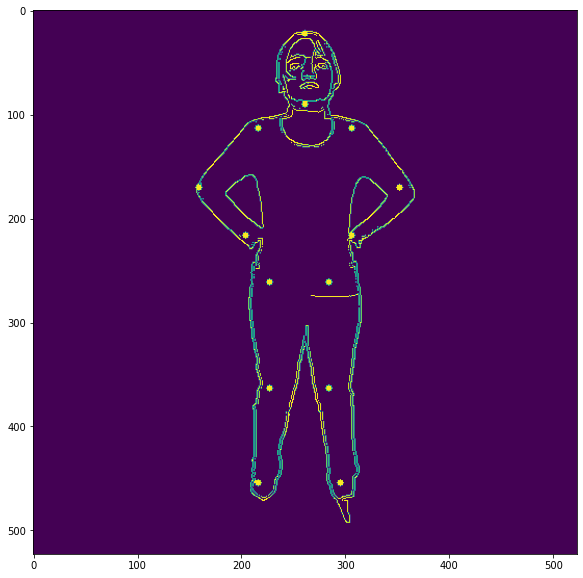

In [39]:
# Plotting the points obtained from openpose on to contour diagram
for i in range(len(points)-1):
	cv2.circle(cnt, (int(points[i][0]),int(points[i][1])),3,(255,255,255),-1)
plt.figure(figsize=[10,10])
imgplot = plt.imshow(cnt)
plt.show()

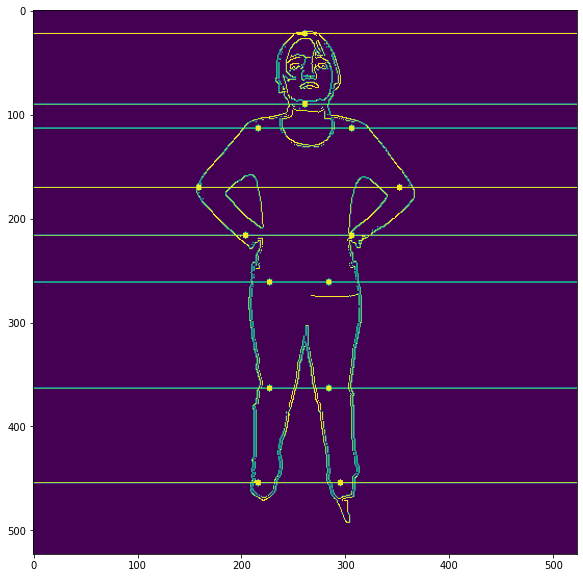

In [40]:
# Understanding the symmetry of human body 

for i in range(len(points)-1):
  cv2.line(cnt, (0,points[i][1]), (800,points[i][1]), (255, 255, 255),1)
  # cv2.line(canny, (points[i][0],0), (points[i][0],1600), (255, 255, 255),1)
plt.figure(figsize=[10,10])
imgplot = plt.imshow(cnt)
plt.show()

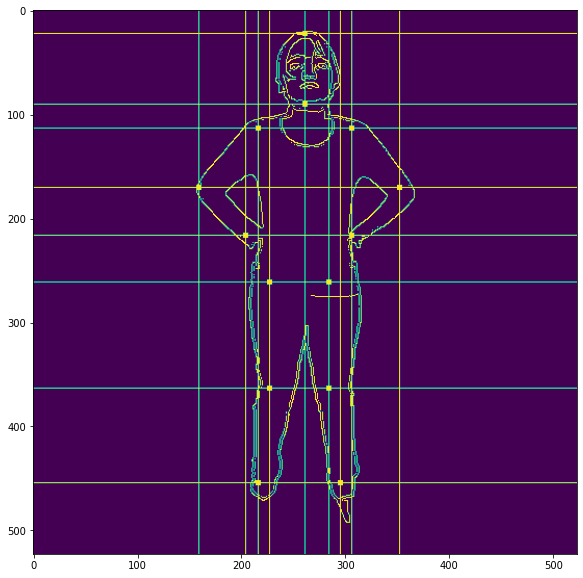

In [41]:
for i in range(len(points)-1):
  cv2.line(cnt, (points[i][0],0), (points[i][0],1600), (255, 255, 255),1)
plt.figure(figsize=[10,10])
imgplot = plt.imshow(cnt)
plt.show()

In [42]:
# Finding the ratio of actual height of the person and the height in the image to know the scale
user_height =int(height)-6         # Ankle error
calculated_height = max(points[13][1] - points[0][1], points[10][1] - points[0][1])      # Height from the image

ratio =user_height/calculated_height
print(ratio)

0.3472222222222222


###Calculating shoulder to shoulder length

In [43]:
# Getting the left shoulder accurate point
ref = points[2]
leftshoulder = []
curr_shoulder=1000
for c in contours:
    for i in c:
        if (i[0][1] <= ref[1]+5 and i[0][1] >= ref[1]-5 and i[0][0]-ref[0]<curr_shoulder):
            curr_shoulder=i[0][0]-ref[0]
            leftshoulder.append(i)

measurement = 800
ansl = []
for i in leftshoulder:
    if ref[0] - i[0][0]<-3:
        continue
    if ref[0]-i[0][0] < measurement:
        measurement = ref[0]-i[0][0]
        ansl = i
if len(ansl) == 0:
    ansl=[ref]

In [44]:
# Getting the right shoulder accurate point

ref = points[5]
rightshoulder = []
curr_shoulder=1000
for c in contours:
    for i in c:
        if (i[0][1] < ref[1]+5 and i[0][1] > ref[1]-5 and ref[0]-i[0][0]<curr_shoulder):
            curr_shoulder=ref[0]-i[0][0]
            rightshoulder.append(i)
measurement = 800
ansr = []
for i in rightshoulder:
    if i[0][0] - ref[0]<-3:
        continue
    elif i[0][0] - ref[0] < measurement:
        measurement = i[0][0] - ref[0]
        ansr = i
if len(ansr) == 0:
    ansr = [ref]

In [45]:
# Actual shoulder measurement

shoulder_measurement = (ansr[0][0]-ansl[0][0]) * ratio
print("Shoulder Measurement:", shoulder_measurement)

Shoulder Measurement: 40.625


###Calculating hip length

In [46]:
ref=points[8]
lefthip=[]
for c in contours:
    for i in c:
        if i[0][1]==ref[1]+1:
            lefthip.append(i)
        if i[0][1]==ref[1]+0:
            lefthip.append(i)
        elif i[0][1]==ref[1]-1:
            lefthip.append(i)

curr_hip=800
lefthippoint=[]
for i in lefthip:
    if ref[0]-i[0][0]<0:
        continue
    elif ref[0]-i[0][0]<curr_hip:
        curr_hip=ref[0]-i[0][0]
        lefthippoint=i

In [47]:
ref=points[11]
righthip=[]
for c in contours:
    for i in c:
        if i[0][1]==ref[1]+1:
            righthip.append(i)
        if i[0][1]==ref[1]+0:
            righthip.append(i)
        elif i[0][1]==ref[1]-1:
            righthip.append(i)

curr_hip=1000
righthippoint=[]

for i in righthip:
    if i[0][0]-ref[0]<0:

        continue
    if i[0][0]-ref[0]<curr_hip:
        curr_hip=i[0][0]-ref[0]
        righthippoint=i

In [48]:
#final hip length
hipmeasurement=(righthippoint[0][0]-lefthippoint[0][0])*ratio
print("Hip:",hipmeasurement)

Hip: 34.72222222222222


In [49]:
#calculating center point 
ref=points[0]
center=[]
for c in contours:
    for i in c:
        if i[0][0]==ref[0]+1:
            center.append(i)
        if i[0][0]==ref[0]:
            center.append(i)
        elif i[0][0]==ref[0]-1:
            center.append(i)

curr_center=0
centerpoint=[]
for i in center:
    if i[0][1]-ref[1]<0:
        continue
    if i[0][1]-ref[1]>curr_hip:
            curr_hip=i[0][1]-ref[1]
            centerpoint=i
print("centerpoint",centerpoint)

centerpoint [[260 323]]


In [50]:
#calculating rise 
rise=centerpoint[0][1]-righthippoint[0][1]
print("Rise:",rise)

Rise: 62


###Calculating the inner and outer seam

In [51]:
# Calculating the innerseam 
# Formula: innerseam = innerankle - centerpoint
ref=points[13]
innerankle=[]
for c in contours:
    for i in c:
        if i[0][1]==ref[1]+1:
            innerankle.append(i)
        if i[0][1]==ref[1]:
            innerankle.append(i)
        elif i[0][1]==ref[1]-1:
            innerankle.append(i)

curr_innerankle=8000
inneranklepoint=[]
for i in innerankle:
    if ref[0]-i[0][0]<0:
        continue
    if ref[0]-i[0][0]<curr_innerankle:
            curr_innerankle=ref[0]-i[0][0]
            inneranklepoint=i
innerseam=math.sqrt(((inneranklepoint[0][1]-centerpoint[0][1])**2)+((inneranklepoint[0][0]-centerpoint[0][0])**2))*ratio
print("Innerseam:",innerseam)

Innerseam: 46.58474953124561


In [52]:
# Calculating the outerseam 
# Formula: outerseam = outeranle - hipextreme
ref=points[13]
outerankle=[]
for c in contours:
    for i in c:
        if i[0][1]==ref[1]+1:
            outerankle.append(i)
        if i[0][1]==ref[1]:
            outerankle.append(i)
        elif i[0][1]==ref[1]-1:
            outerankle.append(i)

curr_outerankle=8000
outerankleepoint=[]
for i in outerankle:
    if ref[0]-i[0][0]>0:
        continue
    if i[0][0]-ref[0]<curr_outerankle:
            curr_outerankle=i[0][0]-ref[0]
            outeranklepoint=i
outerseam=math.sqrt(((inneranklepoint[0][1]-righthippoint[0][1])**2)+((inneranklepoint[0][0]-righthippoint[0][0])**2))*ratio
print("Outerseam:", outerseam)

Outerseam: 68.01036623282849


###Calculating thigh measurements


In [53]:
# Calculating thigh measurements
# This is doneby processing the side image

curr_thigh=0
for c in contours:
    for i in c:
        if(i[0][1] < centerpoint[0][1]+4 and i[0][1] > centerpoint[0][1]-4 and centerpoint[0][0] - i[0][0] > curr_thigh):
            curr_thigh = centerpoint[0][0]-i[0][0]
            thighpoint = i
thightradius = (points[0][0] - thighpoint[0][0]) * ratio/2
thigh = 2 * math.pi * thightradius
print("Thigh measurement:", thigh)

Thigh measurement: 52.359877559829876


###Calculating the sleevs and bust size

In [54]:
# Calculating the sleeve length

# points[2] 
# points[3]
# points[4]

half_sleeve_length = math.sqrt(((ansl[0][0]-points[3][0])**2) + ((ansl[0][1]-points[3][1])**2)) * ratio
full_sleeve_length = half_sleeve_length + math.sqrt(((points[4][0]-points[3][0])**2) + ((points[4][1]-points[3][1])**2)) * ratio
print("Length of half-sleeve:", half_sleeve_length)
print("Length of full-sleeve:", full_sleeve_length)

Length of half-sleeve: 22.779471481745453
Length of full-sleeve: 45.12343056951791


In [55]:
# Calculating the bust size
ref = points[2]
leftarmpit = []
curr_armpit = 1000000
horizontallimit = max(points[7][1],points[4][1])
for c in contours:
    for i in c:
        if(i[0][0] == ref[0] and i[0][1] > ref[1] and i[0][1] < horizontallimit and i[0][1]-ref[1] < curr_armpit):
            leftarmpit = i
bustx = (points[0][0]-leftarmpit[0][0]) * 2 * ratio
print("Bust x:", bustx)

Bust x: 31.25


###Calculating the waist size


In [56]:
# Waist size calculation

ref = min(points[7][1], points[4][1])
current_waist = 1000000
waistpoint=[]
for c in contours:
    for i in c:
        if(i[0][1] == ref or i[0][1] == ref-1 or i[0][1] == ref-2 and i[0][0]-points[0][0] < current_waist and i[0][0] > points[11][0]):
            current_waist = i[0][0]-points[0][0]
            waistpoint = i
waistx = (waistpoint[0][0]-points[0][0]) * 2 * ratio
print("Waist x:", waistx)

Waist x: 29.166666666666664
